# Imports

In [1]:
import data_pipeline

import pandas as pd
import numpy as np
pd.set_option("display.max_colwidth", None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #; sns.set(style="dark"); sns.set_palette("colorblind")

import itertools
import json

# Get the data

In [2]:
SEASON_2019_FILE_NAME = "full_season.json"

In [3]:
with open(SEASON_2019_FILE_NAME, "r") as f:
    data = json.load(f)
    data = list(itertools.chain.from_iterable(data))

##### Threshold 15mins, 25percentile

In [64]:
# min_mins_played prunes all rows with under 14 mins played in that game
df = data_pipeline.stats_endpoint_data_pipeline(data=data, min_mins_played=14)

### Team related indicators: Home/Away

In [65]:
#df['game_object']

In [66]:
df['home_team_id'] = df["game_object"].apply(lambda d: d['home_team_id'])
df['visitor_team_id'] = df["game_object"].apply(lambda d: d['visitor_team_id'])

In [67]:
cols_to_keep = [ 'own_team_id', 'own_team_name',
        'game_id', 'game_winning_team',
       'home_team_id', 'visitor_team_id']

In [68]:
df_team_eval = df[cols_to_keep]

In [69]:
df_team_eval = df_team_eval.drop_duplicates(subset=['own_team_name', 'game_id'])

In [70]:
df_team_eval['played_home'] = (df_team_eval['own_team_id'] == df_team_eval['home_team_id'])*1
df_team_eval['played_away'] = (df_team_eval['own_team_id'] == df_team_eval['visitor_team_id'])*1
df_team_eval['own_team_won'] = (df_team_eval['own_team_id'] == df_team_eval['game_winning_team'])*1

#### Investigating certain players because performance score too high

In [71]:
df_ctk = ['assists', 'blocks', 'defensive_rebounds',
       'three_pt_attempts', 'three_pt_made',
       'two_pt_attempts', 'two_pt_made',
       'one_pt_attempts', 'one_pt_made',
       'offensive_rebounds', 'personal_fouls', 'points', 'rebounds', 'steals',
       'turnovers', 'own_team_name', 'player_id',
       'player_position', 'player_name','mins_played',
        'performance_score','own_team_won']

In [73]:
df[df_ctk].where(df['player_name']=='Mo Bamba').dropna().T
#df.where(df['player_name']=='Jonathan Isaac').dropna()

id,1730859,1735287,1764423,1797627,1806777,1812083,1823880,1556145,1843565,1869796,...,1616743,1625534,1636578,1649929,1662878,1667557,1676048,1702253,1712816,1722339
assists,3,0,1,1,0,1,0,0,1,1,...,1,2,0,0,0,0,0,0,1,1
blocks,1,1,4,1,1,2,1,0,2,1,...,3,2,2,1,0,4,1,1,0,0
defensive_rebounds,5,3,1,6,9,3,4,2,4,6,...,8,4,3,2,8,8,5,3,3,3
three_pt_attempts,1,4,1,3,2,1,2,1,0,1,...,1,5,1,3,1,2,3,4,1,3
three_pt_made,0,1,0,1,0,1,0,0,0,0,...,0,5,1,0,0,2,1,1,1,2
two_pt_attempts,5,9,3,6,5,3,4,1,1,6,...,8,6,6,7,4,4,5,9,6,6
two_pt_made,2,4,2,3,2,2,2,0,0,2,...,3,5,4,2,2,4,1,5,3,5
one_pt_attempts,0,0,0,0,1,0,2,0,0,2,...,0,0,2,0,0,0,2,2,2,1
one_pt_made,0,0,0,0,1,0,1,0,0,1,...,0,0,2,0,0,0,1,2,2,1
offensive_rebounds,2,2,1,0,2,2,1,0,0,5,...,4,0,4,1,0,3,1,1,3,3


### Home/ Away games winratios

In [13]:
# df_home_games = (df_team_eval.where(df_team_eval['played_home']==1).dropna())
# df_away_games = (df_team_eval.where(df_team_eval['played_away']==1).dropna())

# home_standings = df_home_games.groupby('own_team_name').sum()
# home_standings['winratio_at_home'] = round((home_standings['own_team_won']) / (home_standings['played_home']),2)

# away_standings = df_away_games.groupby('own_team_name').sum()
# away_standings['winratio_away'] = round((away_standings['own_team_won']) / (away_standings['played_away']),2)

# ctk_1 = ['own_team_id','winratio_at_home']
# ctk_2 = ['own_team_id','winratio_away']

# home_standings = home_standings[ctk_1]
# away_standings = away_standings[ctk_2]

# winratios = [home_standings['winratio_at_home'],away_standings['winratio_away']]
# winratios = pd.DataFrame(winratios)
# winratios = winratios.T

In [14]:
df_winratios = df_team_eval.groupby(['own_team_name','played_home', 'played_away'],as_index=False).agg({'own_team_won': 'mean'})

df_winratios_home = df_winratios.where(df_winratios['played_home'] == 1).dropna()
df_winratios_away = df_winratios.where(df_winratios['played_home'] == 0).dropna()

df_winratios = pd.merge(df_winratios_home,df_winratios_away,on='own_team_name', how='outer')
df_winratios = df_winratios.rename(columns={'own_team_won_x': 'winrate_home','own_team_won_y': 'winrate_away'})

In [15]:
df_winratios = df_winratios.rename(columns={'own_team_won_x': 'winrate_home','own_team_won_y': 'winrate_away'})

In [16]:
df_winratios

,own_team_name,played_home_x,played_away_x,winrate_home,played_home_y,played_away_y,winrate_away
0,Atlanta Hawks,1.0,0.0,0.424242,0.0,1.0,0.187500
1,Boston Celtics,1.0,0.0,0.718750,0.0,1.0,0.645161
2,Brooklyn Nets,1.0,0.0,0.580645,0.0,1.0,0.387097
3,Charlotte Hornets,1.0,0.0,0.322581,0.0,1.0,0.406250
4,Chicago Bulls,1.0,0.0,0.411765,0.0,1.0,0.258065
5,Cleveland Cavaliers,1.0,0.0,0.305556,0.0,1.0,0.285714
6,Dallas Mavericks,1.0,0.0,0.575758,0.0,1.0,0.625000
7,Denver Nuggets,1.0,0.0,0.781250,0.0,1.0,0.548387
8,Detroit Pistons,1.0,0.0,0.312500,0.0,1.0,0.250000
9,Golden State Warriors,1.0,0.0,0.235294,0.0,1.0,0.206897


### Games played (David)

In [17]:
df_games_played = pd.DataFrame(data=df['player_name'].value_counts())
df_games_played = df_games_played.reset_index()
df_games_played.columns = ['player_name', 'games_played'] # change column names

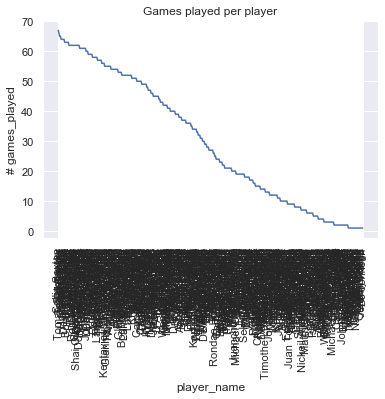

In [18]:
plt.figure()
plt.plot(df_games_played['player_name'], df_games_played['games_played'])
plt.xlabel('player_name')
plt.ylabel("# games_played")
plt.title("Games played per player")
plt.xticks(rotation=90)
plt.show();

In [19]:
df_games_played.describe()

,games_played
count,427.000000
mean,29.814988
std,21.200606
min,1.000000
25%,10.000000
50%,27.000000
75%,51.000000
max,67.000000


##### Threshold 14 games, 25percentile

In [20]:
df2 = df.merge(df_games_played, left_on='player_name', right_on='player_name')
df3 = df2.loc[df2['games_played'] > 13]
print(len(df2),len(df3))
print(len(df3)/len(df2))

12731 11935
0.937475453617155


In [21]:
df = df3.copy()
del df2; del df3

In [22]:
df

,assists,blocks,defensive_rebounds,three_pt_percentage,three_pt_attempts,three_pt_made,two_pt_percentage,two_pt_attempts,two_pt_made,one_pt_percentage,...,game_id,mins_played,secs_played,performance_score,game_winning_team,own_team_won,team_points_share,home_team_id,visitor_team_id,games_played
0,8,1,8,20.0,5,1,36.8,19,7,75.0,...,62585,36.0,0.0,39.914330,13,False,0.176471,13,14,59
1,9,0,8,0.0,6,0,40.0,20,8,50.0,...,62985,34.0,54.0,39.784030,12,False,0.196078,12,14,59
2,11,0,12,42.9,7,3,42.1,19,8,100.0,...,63000,36.0,44.0,50.710594,17,False,0.201923,17,14,59
3,11,1,10,33.3,6,2,52.6,19,10,88.9,...,62683,35.0,11.0,69.875776,14,True,0.254237,5,14,59
4,10,1,6,16.7,12,2,37.5,24,9,75.0,...,63041,38.0,49.0,54.268736,13,False,0.216981,14,13,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12608,1,1,3,0.0,4,0,11.1,9,1,100.0,...,62862,21.0,49.0,24.540518,14,False,0.067961,14,30,15
12609,1,0,9,0.0,4,0,33.3,6,2,50.0,...,62899,25.0,57.0,37.931034,30,True,0.042017,30,23,15
12610,1,0,7,25.0,4,1,50.0,14,7,100.0,...,62907,30.0,35.0,45.348837,16,False,0.184466,16,30,15
12611,3,1,3,0.0,2,0,42.9,7,3,100.0,...,62935,25.0,44.0,37.104072,4,False,0.084112,4,30,15


# Analysis

## Performance score distribution

In [23]:
PERF_GRADING_NUMERIC_COLS = data_pipeline.PERF_GRADING_NUMERIC_COLS
# ["assists", "blocks", "rebounds", "points", "steals", "turnovers", "personal_fouls","one_pt_attempts","two_pt_attempts","three_pt_attempts"]

In [24]:
df['three_pt_attempts'].unique()

array([ 5,  6,  7, 12,  4,  3,  9,  2,  8, 10, 11,  1,  0, 13, 20, 15, 14,
       16, 17, 21, 19, 22, 18], dtype=int64)

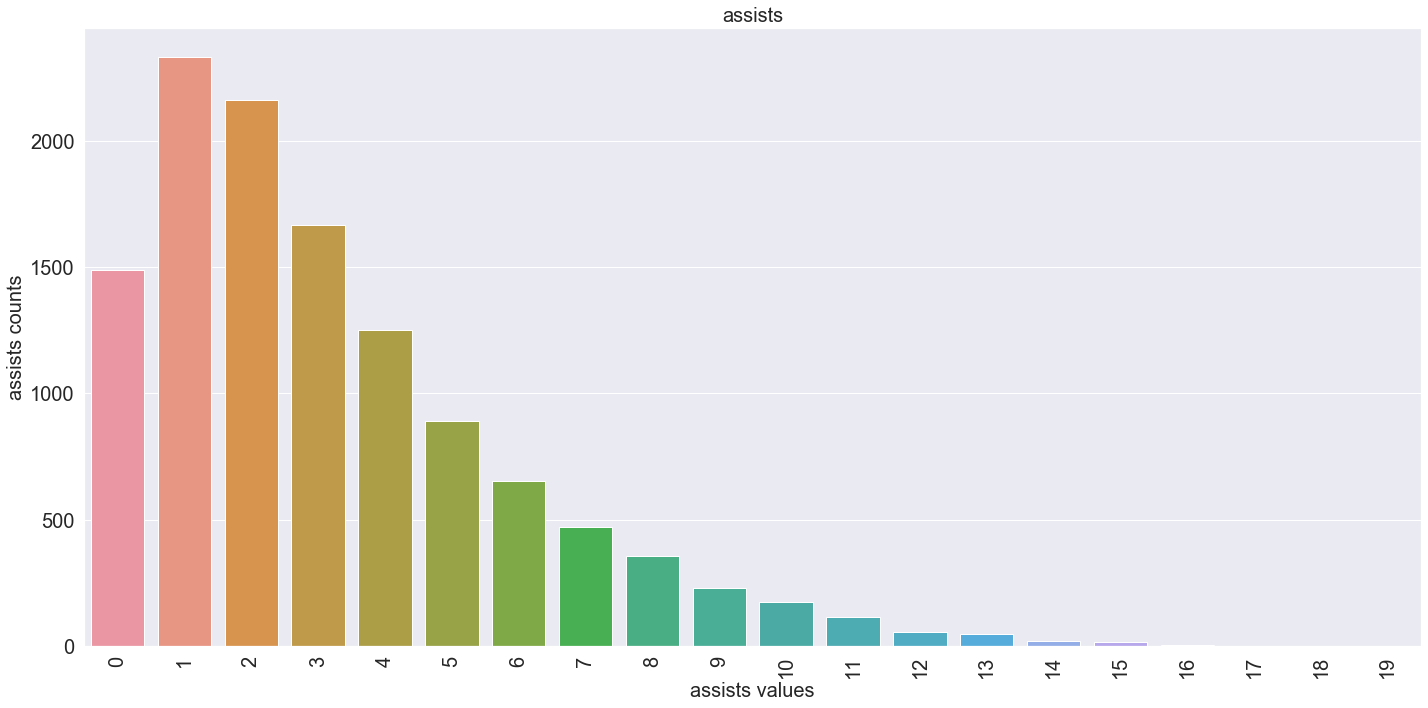

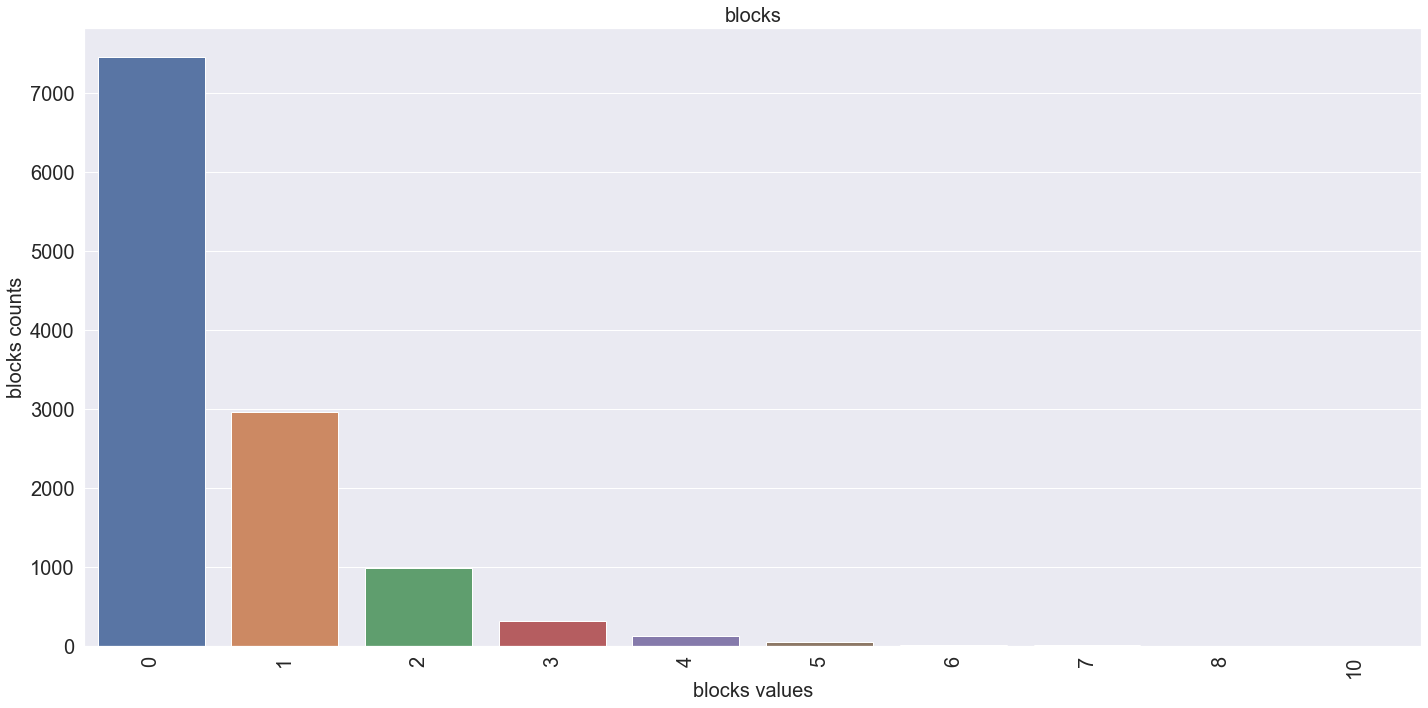

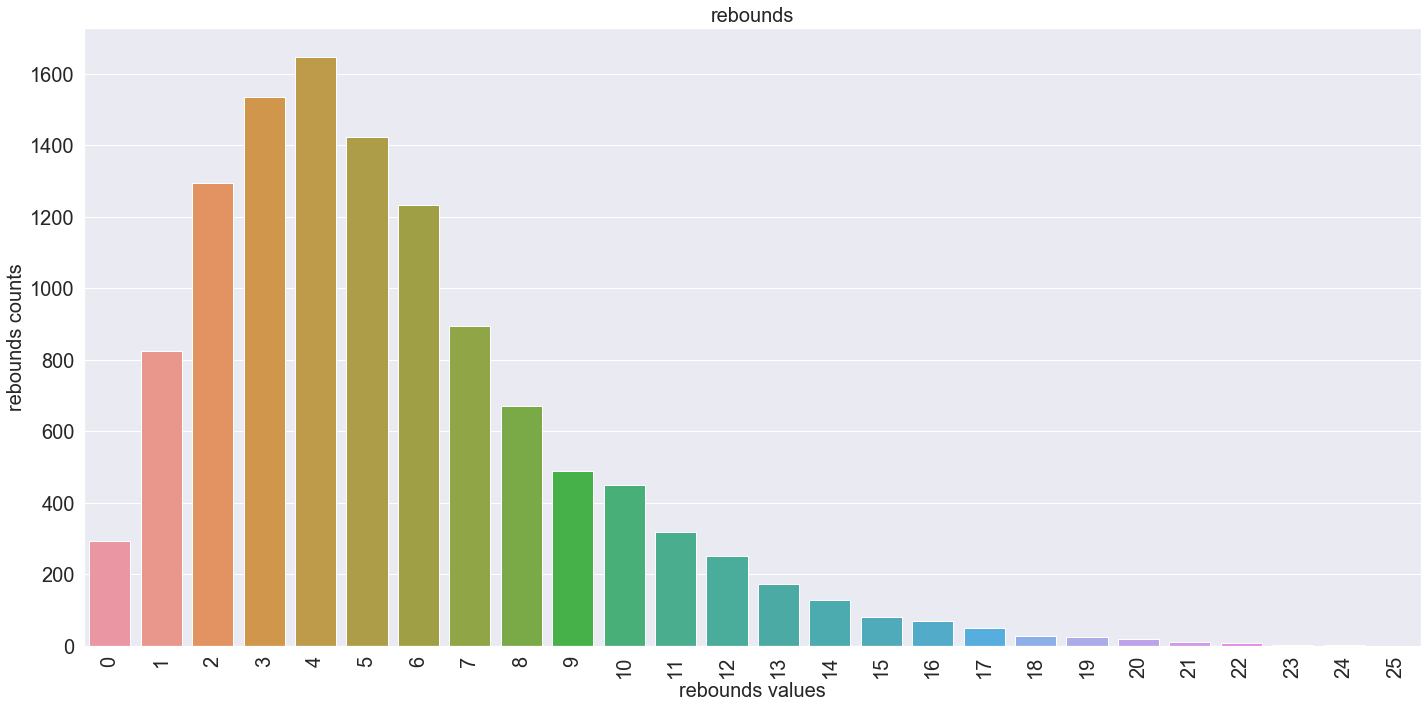

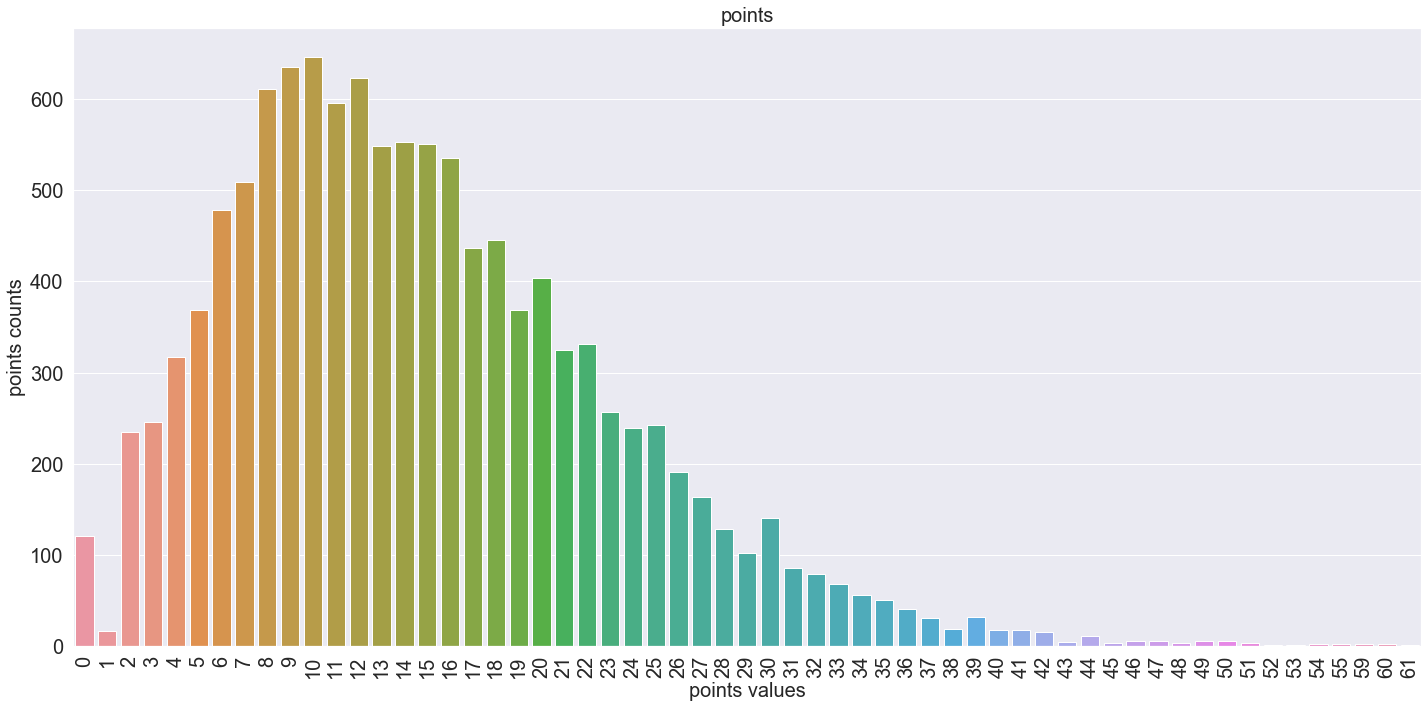

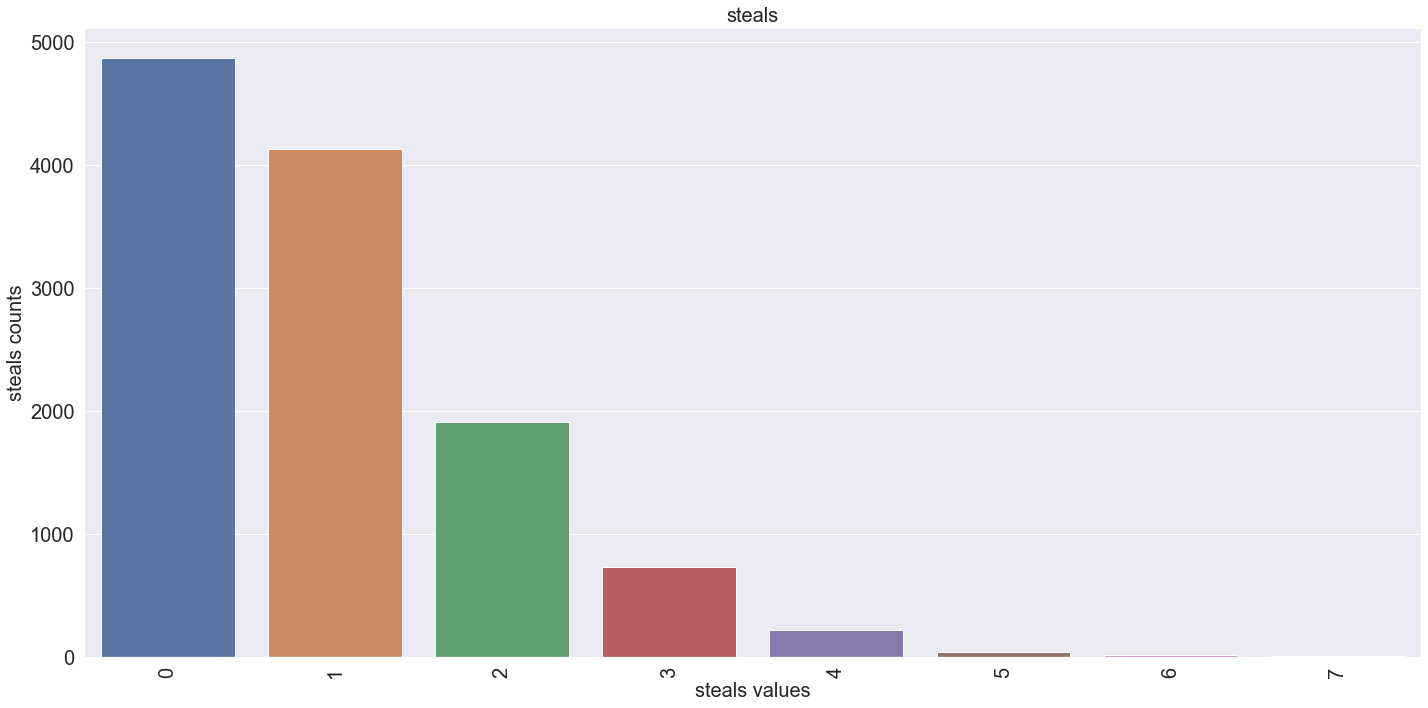

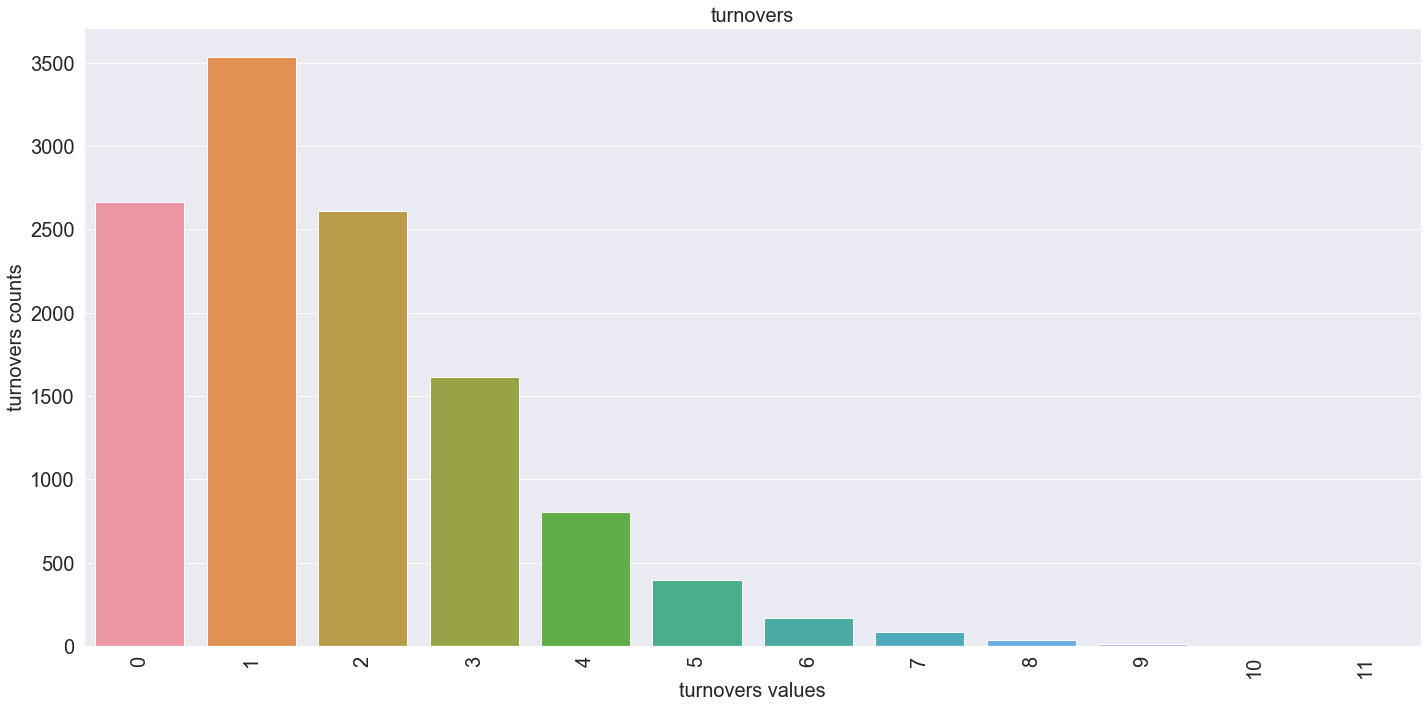

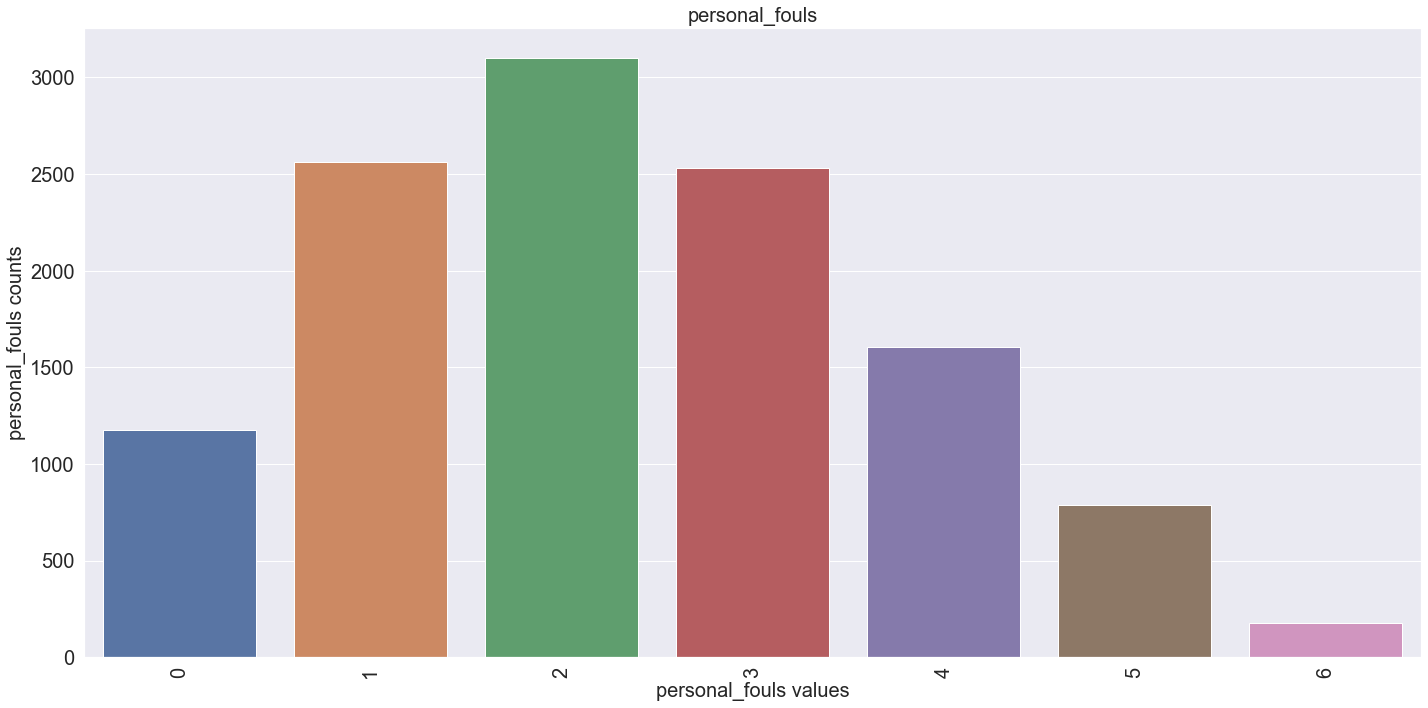

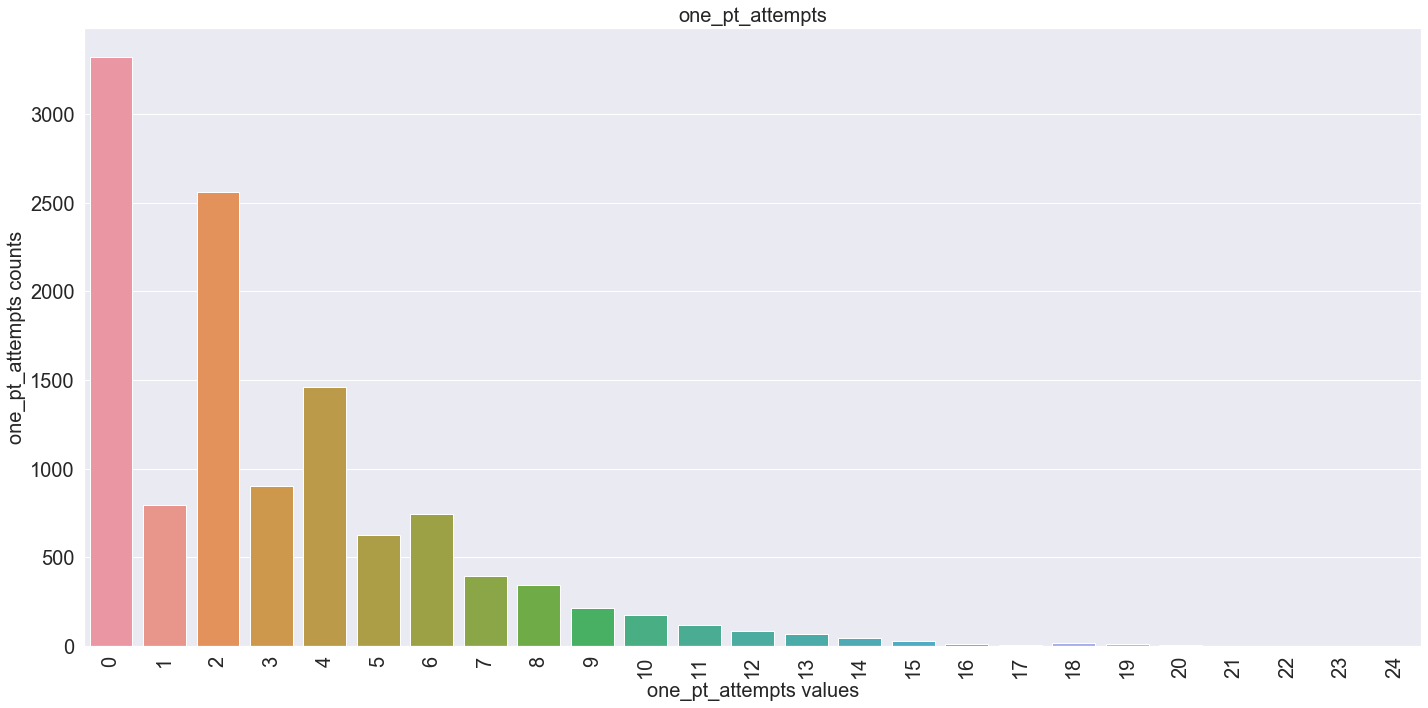

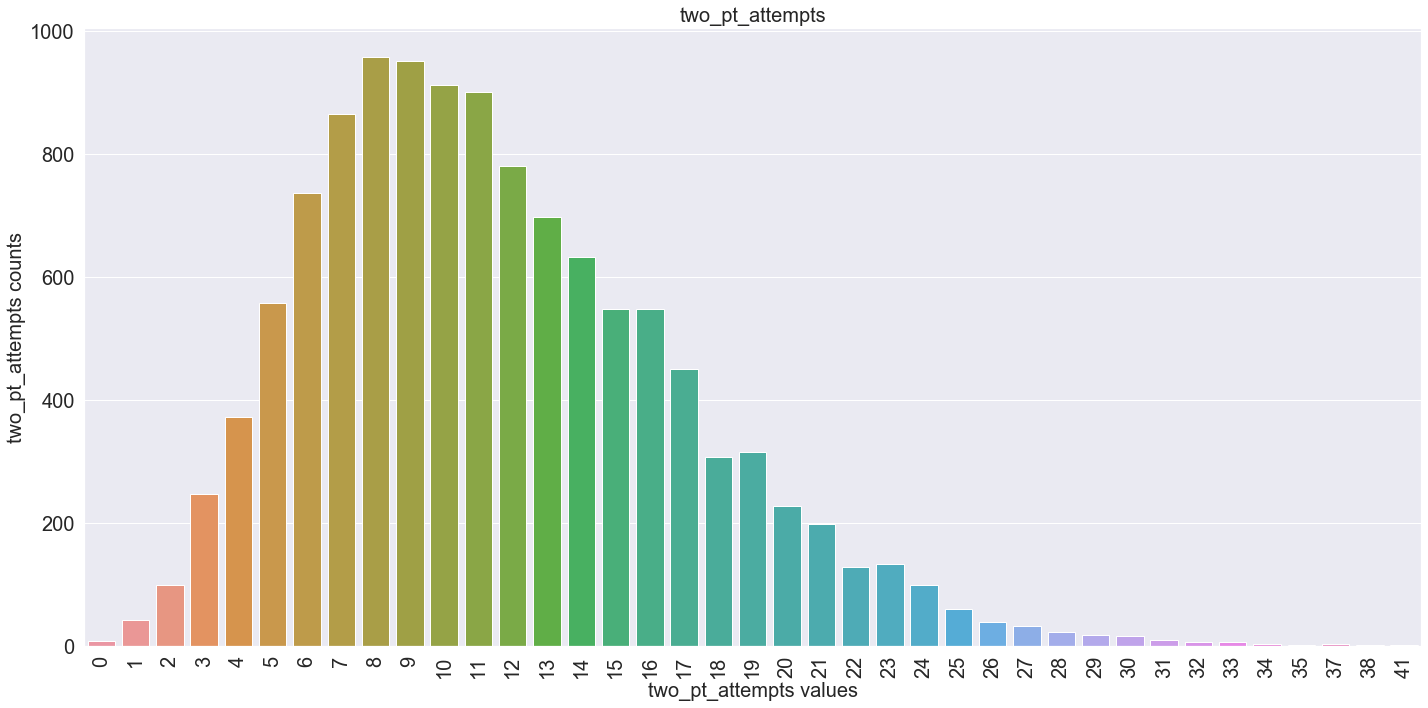

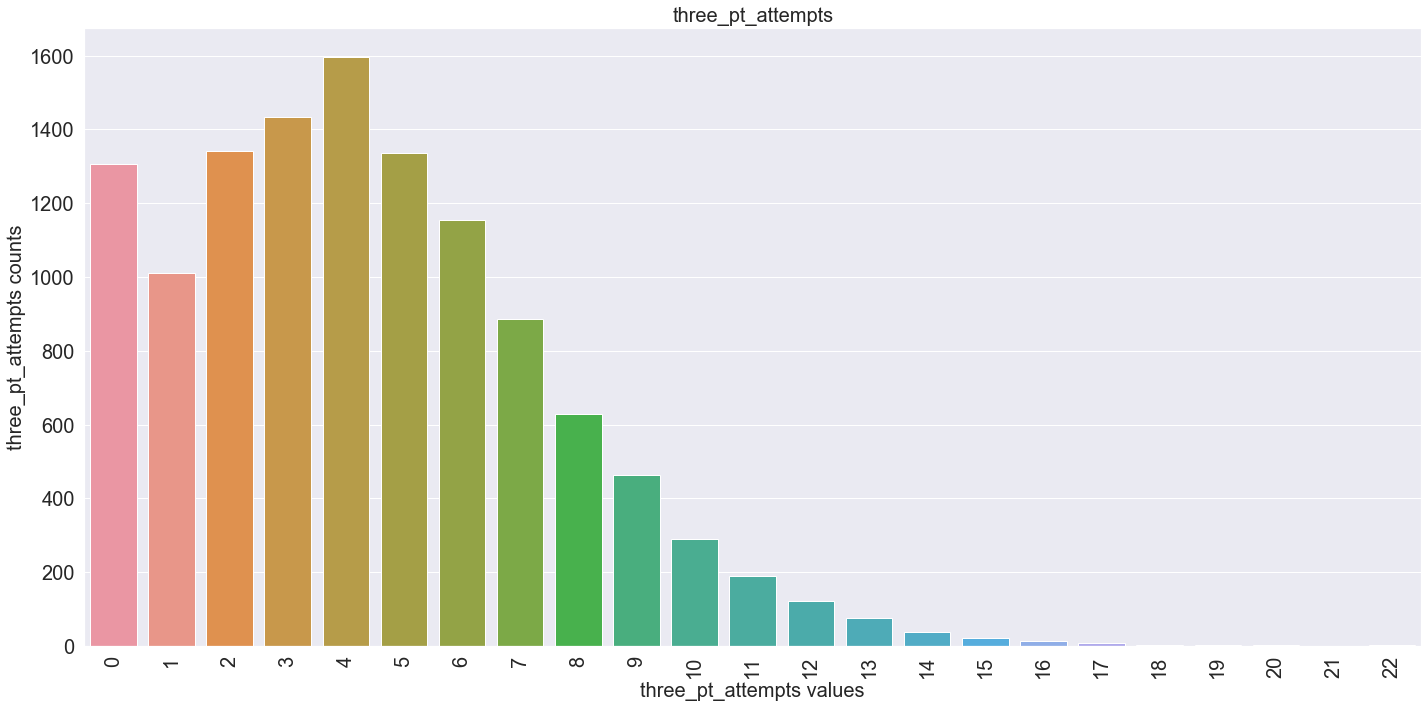

In [25]:
# plt.rc("font", size=20)
plt.rc("axes", labelsize=20)
plt.rc("axes", titlesize=20)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

for col in PERF_GRADING_NUMERIC_COLS:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax = sns.countplot(data=df, x=col, ax=ax)
#     ax = df[col].value_counts().plot.bar(order=df[col].value_counts().index)
    ax.set(xlabel=f"{col} values", ylabel=f"{col} counts", title=col)
    plt.xticks(rotation=90)
    plt.tight_layout();
    plt.show();

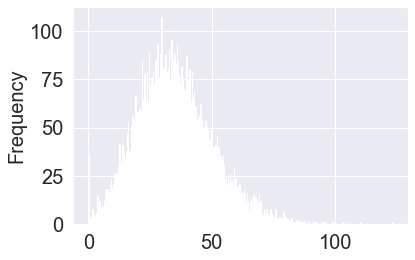

In [26]:
df.performance_score.plot.hist(bins=500);

## Analyzing any particular team

In [27]:
def analyze_team(team_name: str, **kwargs) -> None:
    team_df = df.loc[df.own_team_name == team_name]
    if team_df.empty:
        return
    return team_df.groupby("player_name").agg({"performance_score": ["mean", "std"]})\
        .sort_values(by=("performance_score", "mean")).plot.bar(title=team_name);

C:\Users\DG\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


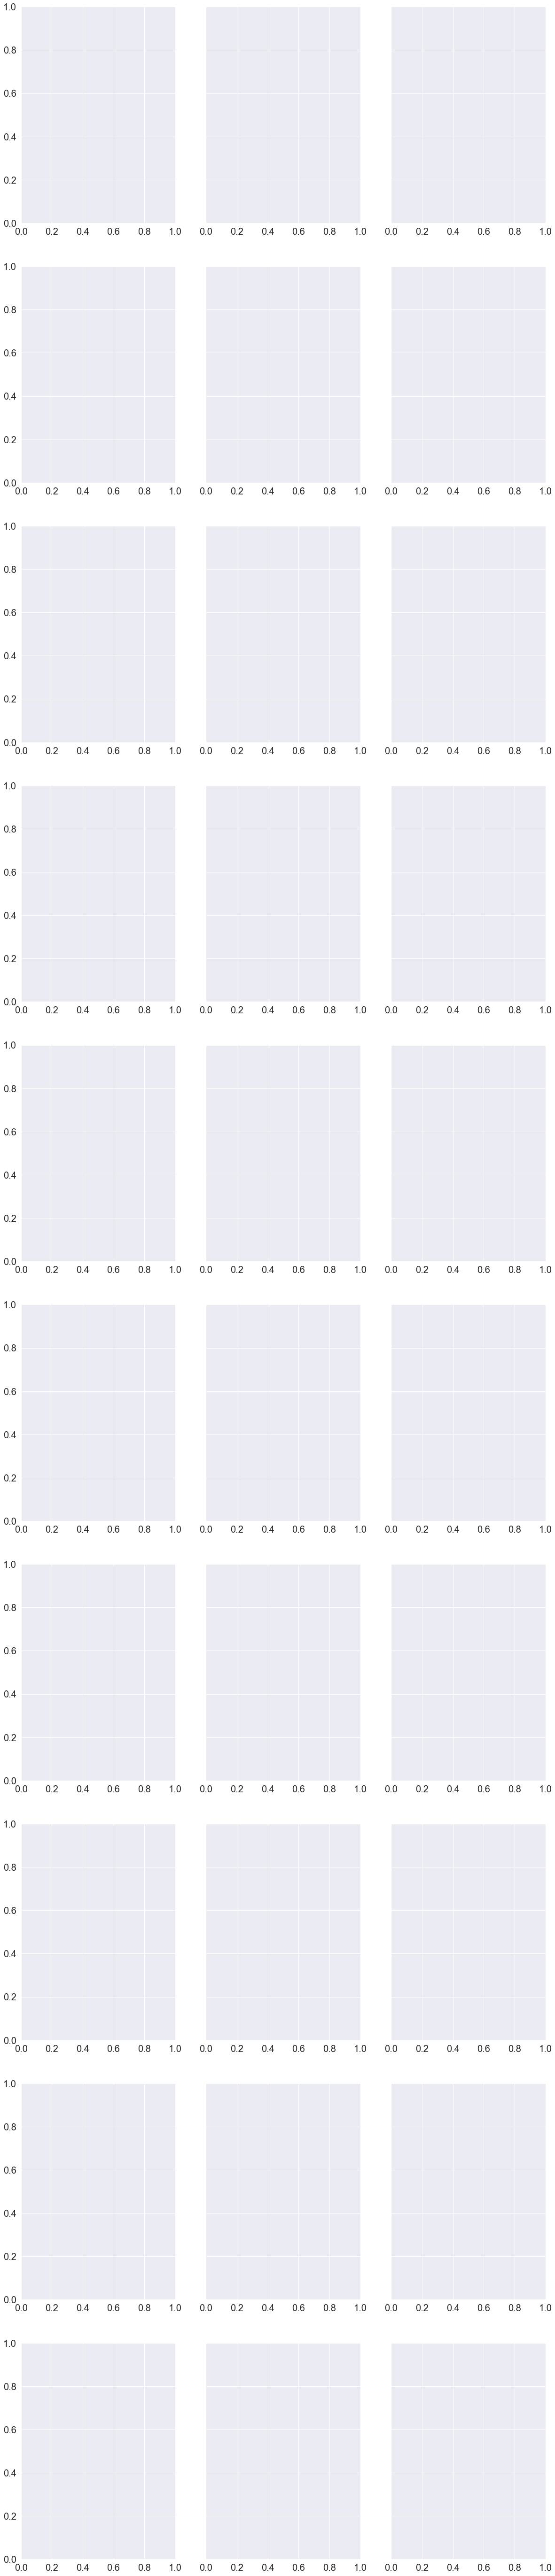

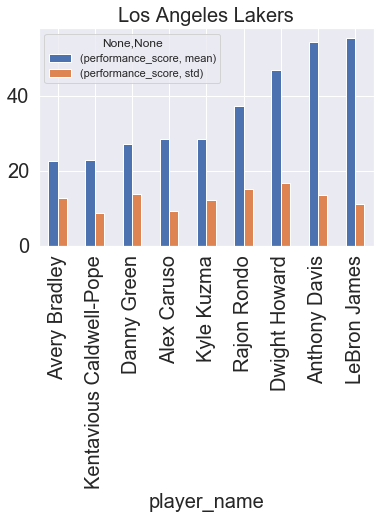

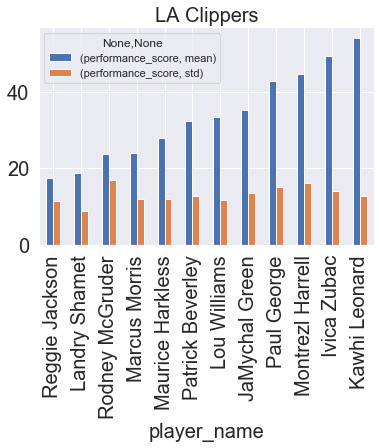

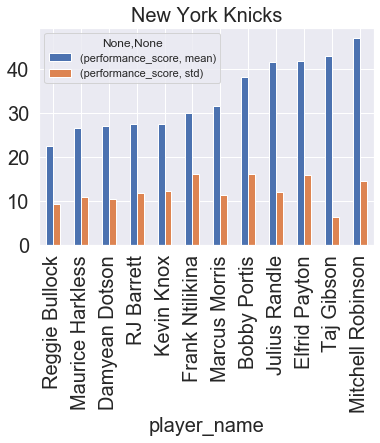

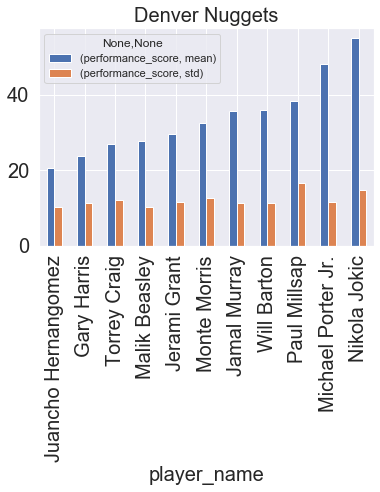

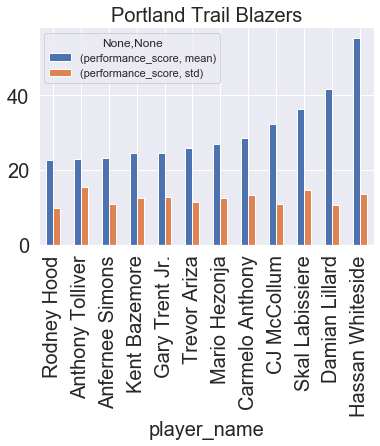

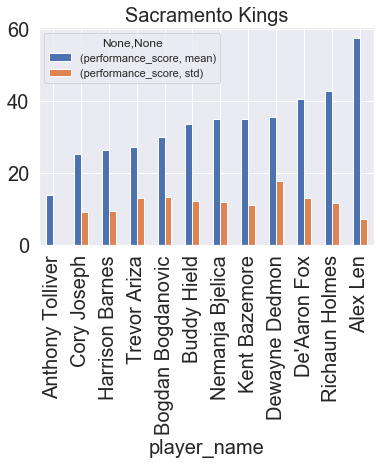

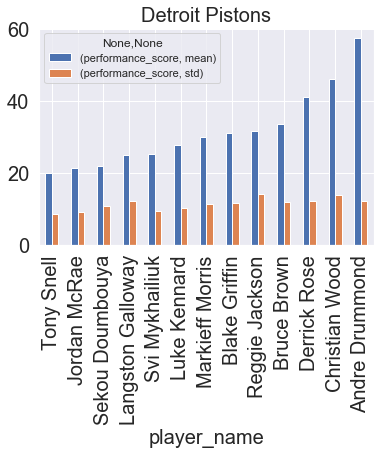

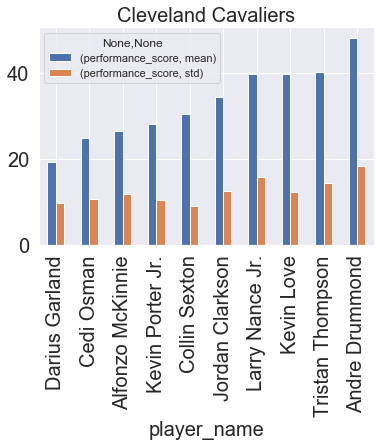

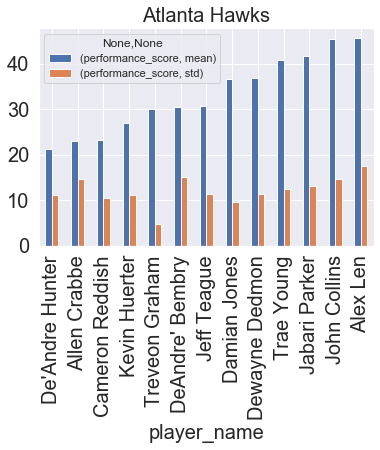

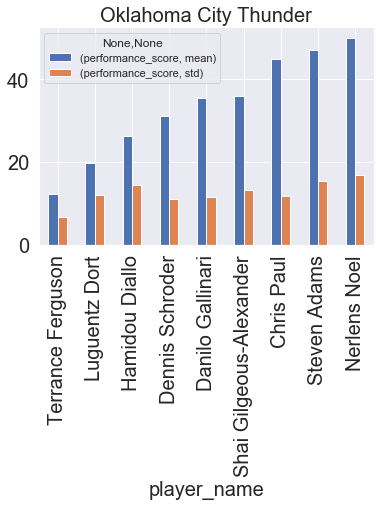

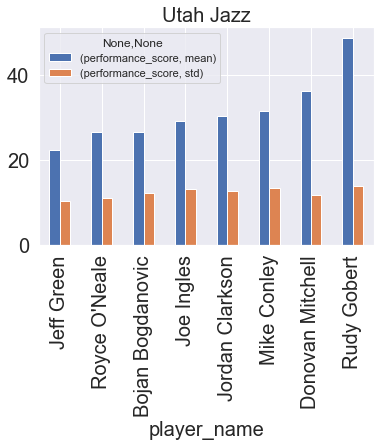

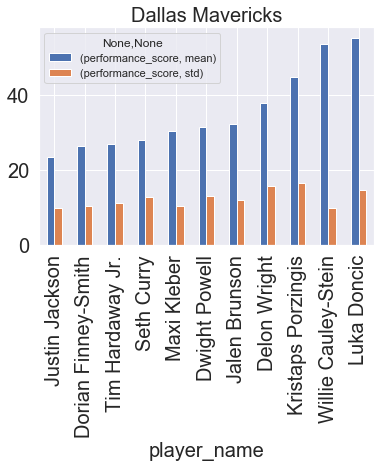

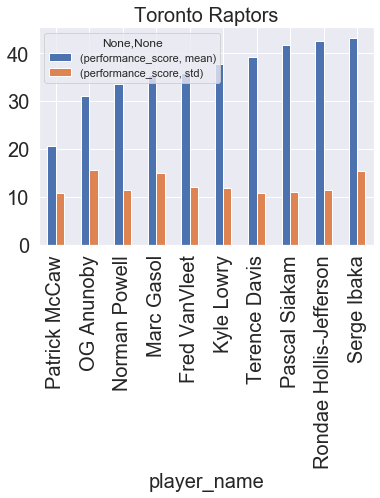

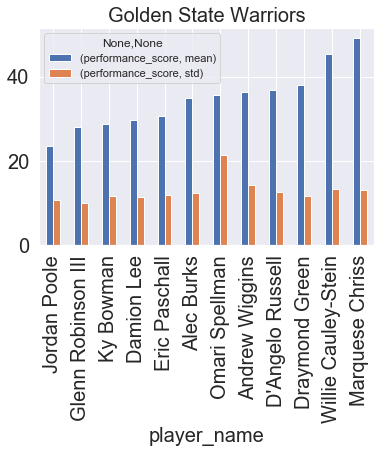

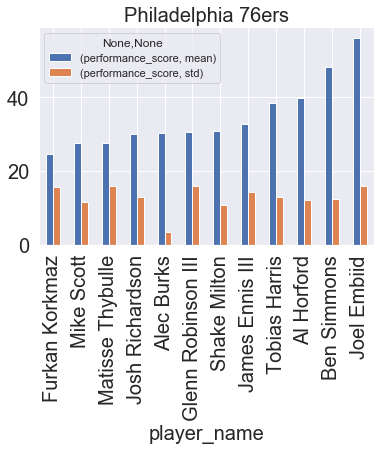

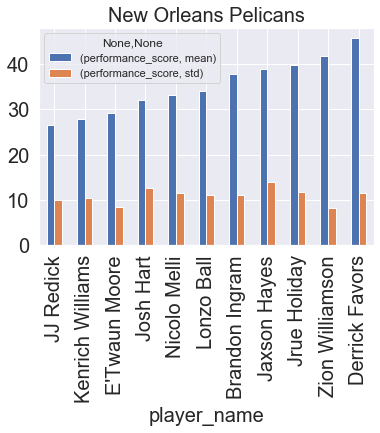

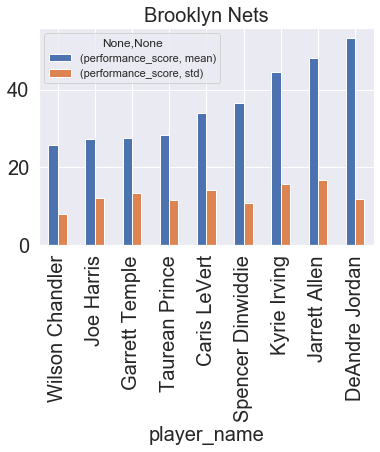

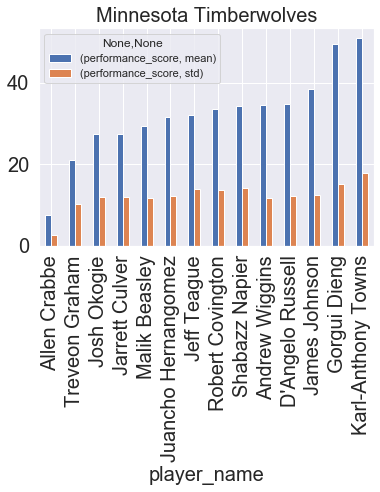

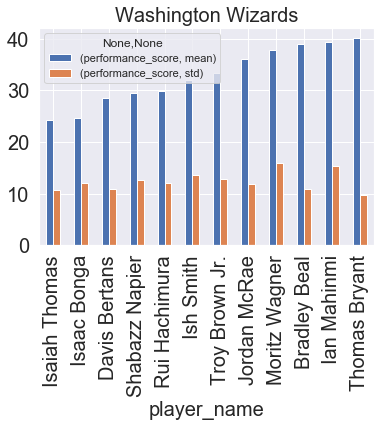

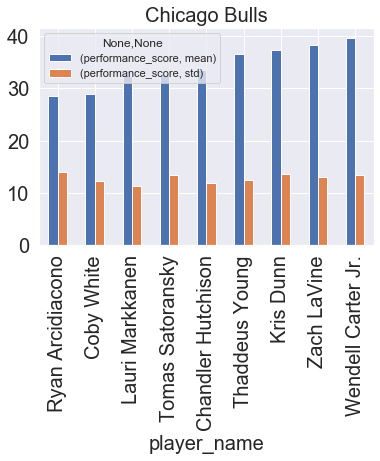

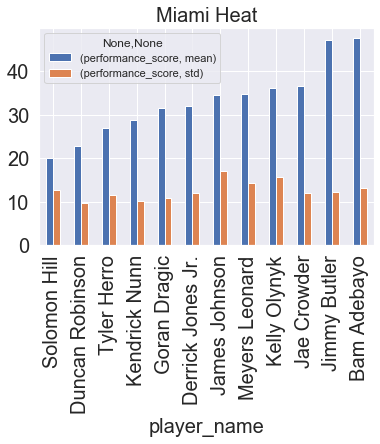

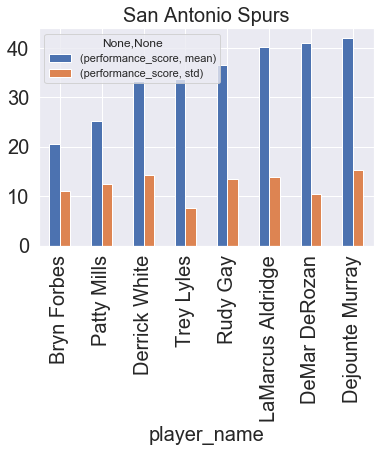

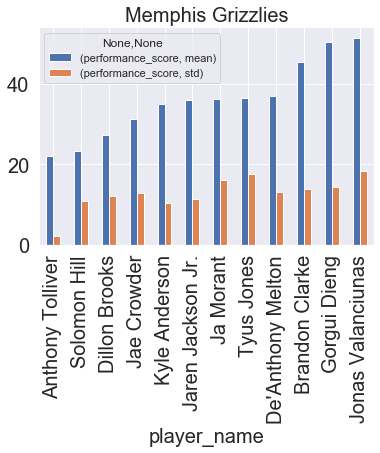

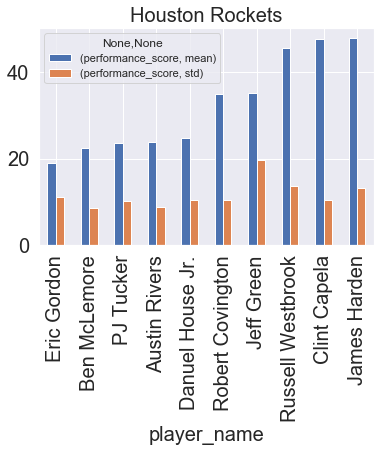

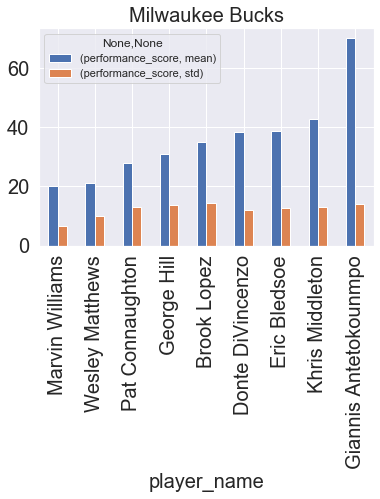

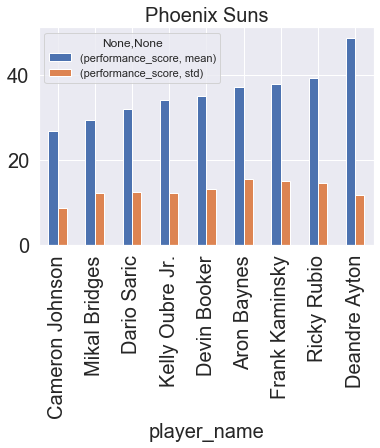

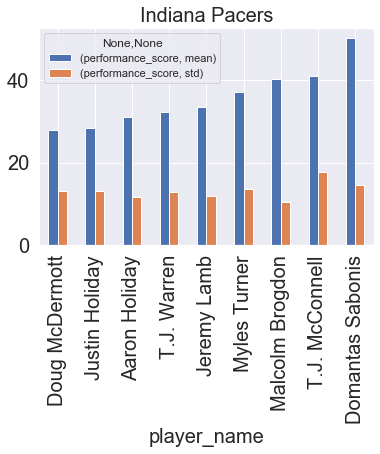

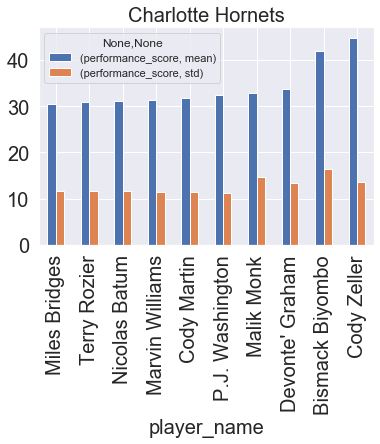

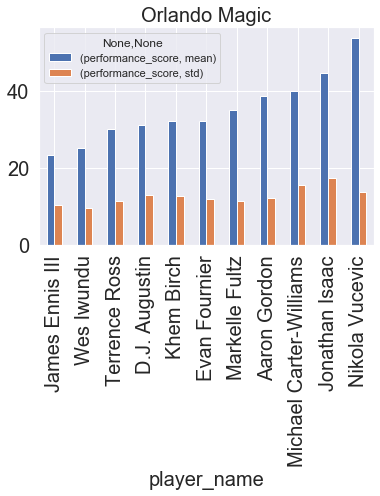

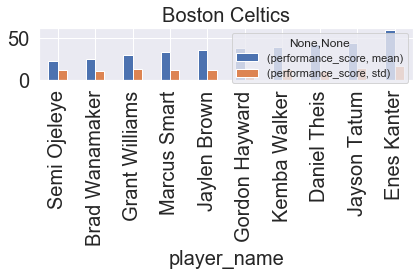

In [28]:
# analyze_team("Milwaukee Bucks")
team_names = list(df.own_team_name.unique())
fig, ax = plt.subplots(nrows=len(team_names) // 3 + len(team_names) % 3, ncols=3, sharey=True)
fig.set_figheight(100); fig.set_figwidth(20)
for idx, team in enumerate(team_names):
    plot = analyze_team(team, ax=ax, pos=idx)
    x_plot_pos, y_plot_pos = idx // 3, idx % 3
    ax[x_plot_pos, y_plot_pos] = plot

plt.tight_layout()
plt.show();

## Inspecting correlation between performance_score and winning

In [29]:
df_summed = df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": "mean"})

In [30]:
df_summed.reset_index(inplace=True)
df_summed["is_winning_team"] = df_summed\
    .apply(lambda x: x['own_team_id'] == x["game_winning_team"], axis=1)
df_summed["has_highest_score"] = df_summed\
    .apply(lambda s: s["performance_score"] == df_summed.groupby("game_id")\
               .agg({"performance_score": "max"}).loc[s.game_id], axis=1)

df_summed["highest_score_did_win"] = df_summed.apply(lambda s: s.is_winning_team == s.has_highest_score, axis=1)
df["home_team_did_win"] = df.apply(lambda s: s["game_winning_team"] == s["game_object"].get("home_team_id"), axis=1)

#### ?????

In [31]:
dcols = ['own_team_name','performance_score','game_winning_team','own_team_id']
df[dcols].head(20)

,own_team_name,performance_score,game_winning_team,own_team_id
0,Los Angeles Lakers,39.914330,13,14
1,Los Angeles Lakers,39.784030,12,14
2,Los Angeles Lakers,50.710594,17,14
3,Los Angeles Lakers,69.875776,14,14
4,Los Angeles Lakers,54.268736,13,14
5,Los Angeles Lakers,60.763889,14,14
6,Los Angeles Lakers,55.056505,14,14
7,Los Angeles Lakers,67.257989,14,14
8,Los Angeles Lakers,53.825011,14,14
9,Los Angeles Lakers,63.414634,14,14


In [32]:
df_summed.columns

Index(['game_id', 'own_team_id', 'game_winning_team', 'performance_score',
       'is_winning_team', 'has_highest_score', 'highest_score_did_win'],
      dtype='object')

In [33]:
team_winrates_df = df.drop_duplicates(subset=["game_id", "own_team_id"], inplace=False)

In [34]:
team_winrates_df.groupby("own_team_id").agg({"own_team_won": "sum"})

,own_team_won
own_team_id,
1,20.0
2,43.0
3,30.0
4,23.0
5,22.0
6,19.0
7,39.0
8,42.0
9,18.0


In [35]:
# in 81% of all games, the team with the higher avg. performance score
# (across all its players with > mins_played_threshold := 14)
# also wins the game.
df_summed.highest_score_did_win.value_counts() / (df_summed.highest_score_did_win.value_counts().sum())

True     0.771186
False    0.228814
Name: highest_score_did_win, dtype: float64

In [36]:
df.groupby(["game_id", "own_team_id", "game_winning_team"])\
    .agg({"performance_score": ["sum", "mean", "max", "count"]})[:50]

performance_score             \
                                                    sum       mean   
game_id own_team_id game_winning_team                                
62585   13          13                       222.439662  37.073277   
        14          13                       163.620469  32.724094   
62586   4           4                        141.183052  28.236610   
        5           4                        253.020273  36.145753   
62588   6           22                       233.498994  38.916499   
        22          22                       258.574009  43.095668   
62592   7           7                        215.850382  30.835769   
        30          7                        251.602945  35.943278   
62594   8           8                        205.740755  34.290126   
        25          8                        182.598618  36.519724   
62595   24          24                       270.470296  45.078383   
        26          24                       137.933058  19.704723   
62596   21          29                       219.261589  31.323084   
        29          29                       187.120530  31.186755   
62597   1           1                        263.370531  37.624362   
        9           1                        186.877997  31.146333   
62598   11          17                       212.356391  35.392732   
        17          17                       220.743255  44.148651   
62599   10          13                       120.611527  24.122305   
        13          13                       203.448694  33.908116   
62600   2           2                        231.566109  38.594352   
        28          2                        192.935241  27.562177   
62601   4           18                        87.324393  29.108131   
        18          18                       301.231907  50.205318   
62602   3           3                        206.078505  29.439786   
        20          3                        119.410679  23.882136   
62603   5           5                        291.299110  41.614159   
        15          5                        246.898551  41.149759   
62605   7           7                        266.630434  38.090062   
        19          7                        231.769906  33.109987   
62606   8           8                        254.457894  31.807237   
        24          8                        201.693635  33.615606   
62609   16          16                       201.622757  28.803251   
        17          16                       159.858091  26.643015   
62610   9           23                       216.285355  36.047559   
        23          23                       200.888275  33.481379   
62611   1           1                        229.540633  38.256772   
        22          1                        245.134141  35.019163   
62612   2           2                        218.489518  43.697904   
        20          2                        171.861501  28.643584   
62613   6           6                        186.616627  31.102771   
        12          6                        191.351100  31.891850   
62614   5           28                       153.516377  30.703275   
        28          28                       345.729368  49.389910   
62615   11          11                       195.336503  32.556084   
        19          11                       151.578002  30.315600   
62617   26          29                       136.775629  19.539376   
        29          29                       244.245939  40.707656   
62618   13          24                       159.171212  31.834242   
        24          24                       230.158584  38.359764   

                                                         
                                              max count  
game_id own_team_id game_winning_team                    
62585   13          13                  49.366898     6  
        14          13                  58.046145     5  
62586   4           4                

#### Players avg performance+std 

In [37]:
df.columns

Index(['assists', 'blocks', 'defensive_rebounds', 'three_pt_percentage',
       'three_pt_attempts', 'three_pt_made', 'two_pt_percentage',
       'two_pt_attempts', 'two_pt_made', 'one_pt_percentage',
       'one_pt_attempts', 'one_pt_made', 'game_object', 'min',
       'offensive_rebounds', 'personal_fouls', 'points', 'rebounds', 'steals',
       'turnovers', 'own_team_id', 'own_team_name', 'player_id',
       'player_position', 'player_name', 'game_id', 'mins_played',
       'secs_played', 'performance_score', 'game_winning_team', 'own_team_won',
       'team_points_share', 'home_team_id', 'visitor_team_id', 'games_played',
       'home_team_did_win'],
      dtype='object')

In [38]:
df_eval = df.loc[:,['player_name', 'performance_score','own_team_id', 'own_team_name',]]
df_eval = df_eval.groupby(['own_team_name',"player_name"]).agg({"performance_score": ["mean", "std"]})

In [39]:
df_eval

performance_score           
                                                mean        std
own_team_name      player_name                                 
Atlanta Hawks      Alex Len                45.563475  17.454689
                   Allen Crabbe            22.897952  14.577444
                   Cameron Reddish         23.283500  10.412795
                   Damian Jones            36.633484   9.562846
                   De'Andre Hunter         21.334607  11.168162
...                                              ...        ...
Washington Wizards Moritz Wagner           37.744968  15.876699
                   Rui Hachimura           29.905079  11.983391
                   Shabazz Napier          29.518013  12.569848
                   Thomas Bryant           40.124896   9.824919
                   Troy Brown Jr.          33.454600  12.769558

[321 rows x 2 columns]

In [40]:
df_performance_eval = pd.DataFrame(df_eval)
df_performance_eval = df_performance_eval.reset_index()
df_performance_eval.columns = ['own_team_name','player_name', 'avg_performance_score','avg_performance_deviation'] # change column name
#df_performance_eval = df_performance_eval.set_index(['player_name'])
#df_performance_eval.where(df_performance_eval['own_team_name']=='Los Angeles Lakers').dropna()

In [41]:
df_performance_eval.where(df_performance_eval['own_team_name']=='Detroit Pistons').dropna()

,own_team_name,player_name,avg_performance_score,avg_performance_deviation
83,Detroit Pistons,Andre Drummond,57.471149,12.188678
84,Detroit Pistons,Blake Griffin,30.972867,11.801361
85,Detroit Pistons,Bruce Brown,33.512149,11.822287
86,Detroit Pistons,Christian Wood,45.995496,13.832804
87,Detroit Pistons,Derrick Rose,41.006682,12.162653
88,Detroit Pistons,Jordan McRae,21.389301,9.128620
89,Detroit Pistons,Langston Galloway,24.950422,12.093934
90,Detroit Pistons,Luke Kennard,27.656213,10.236826
91,Detroit Pistons,Markieff Morris,29.950892,11.320661
92,Detroit Pistons,Reggie Jackson,31.745572,14.132334


In [42]:
team_names = df_performance_eval['own_team_name'].unique()
team_names = list(team_names)

#### Playinh around with how many players should be taken into consideration for team_avg_performance

In [43]:
team_top5_performer = []
for team in team_names:
    temp = df_performance_eval.where(df_performance_eval['own_team_name'] == team).dropna().sort_values(by="avg_performance_score")[-5:]
    team_top5_performer.append(temp)
team_top5_performer = pd.concat(team_top5_performer)

In [44]:
team_top5_performer = team_top5_performer.groupby('own_team_name').agg({'avg_performance_score':'mean','avg_performance_deviation':'mean'})

team_top5_performer = pd.DataFrame(team_top5_performer)
team_top5_performer = team_top5_performer.reset_index()
team_top5_performer.columns = ['own_team_name','team_top5_avg_performance_score','team_top5_avg_performance_deviation']

In [45]:
team_top5_performer

,own_team_name,team_top5_avg_performance_score,team_top5_avg_performance_deviation
0,Atlanta Hawks,42.082389,13.801286
1,Boston Celtics,44.252605,13.919760
2,Brooklyn Nets,43.271718,13.923914
3,Charlotte Hornets,37.163779,13.798828
4,Chicago Bulls,37.056166,12.940461
5,Cleveland Cavaliers,40.495011,14.749714
6,Dallas Mavericks,44.759009,13.723683
7,Denver Nuggets,42.574545,13.118169
8,Detroit Pistons,41.946210,12.827751
9,Golden State Warriors,41.120196,13.035817


In [46]:
#### Nonsense upcoming

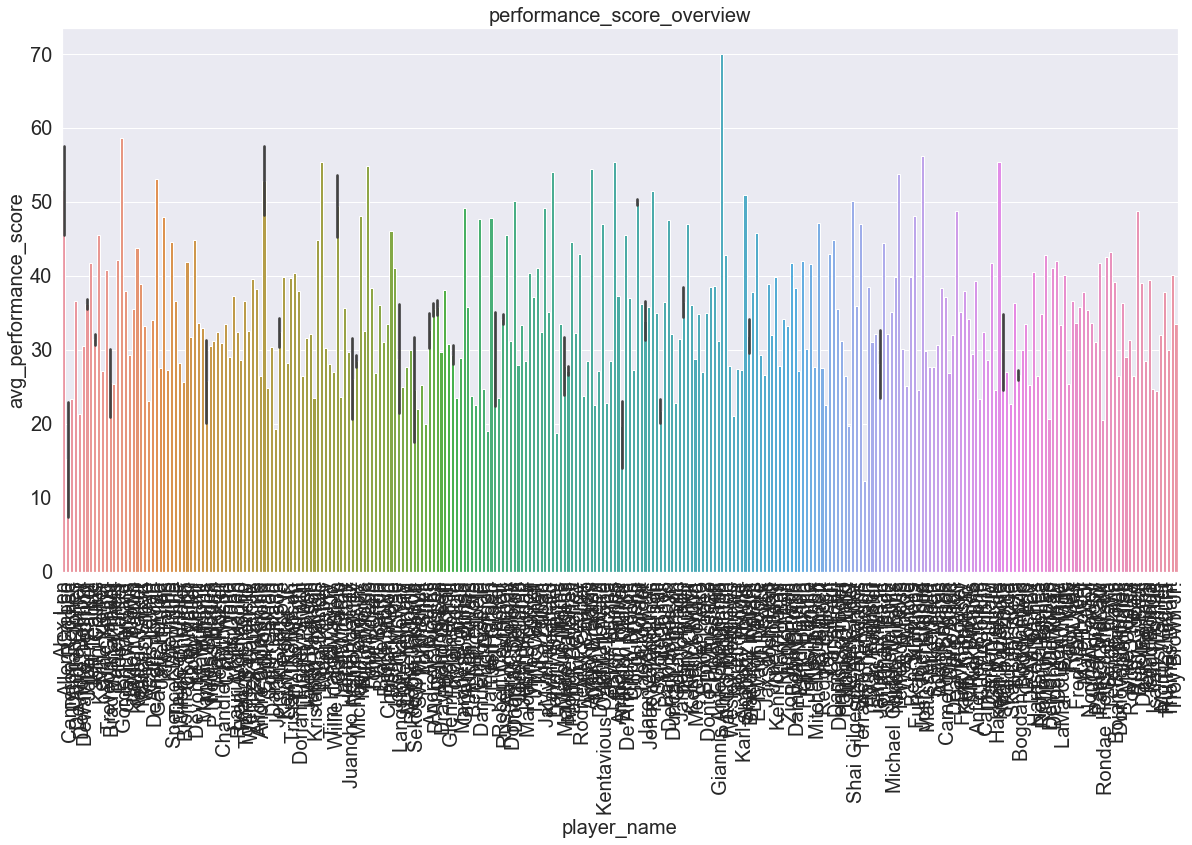

In [47]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="avg_performance_score", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['avg_performance_score'])
plt.xlabel('player_name')
plt.ylabel("avg_performance_score")
plt.title("performance_score_overview")
plt.xticks(rotation=90)
plt.show();

In [48]:
df_performance_eval.describe()

,avg_performance_score,avg_performance_deviation
count,321.000000,320.000000
mean,34.085909,12.415034
std,9.136257,2.461977
min,7.421838,2.245178
25%,27.625974,11.084262
50%,33.164337,12.162673
75%,39.279436,13.719434
max,69.989078,21.307358


In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
df_performance_eval.columns

Index(['own_team_name', 'player_name', 'avg_performance_score',
       'avg_performance_deviation'],
      dtype='object')

In [51]:
scaler = MinMaxScaler()
df_performance_eval['scaled_perf'] = (scaler.fit_transform(df_performance_eval['avg_performance_score'].values.reshape(-1,1)))*100
df_performance_eval['scaled_perf']  = round(df_performance_eval['scaled_perf'],2)

df_performance_eval['scaled_std'] = (scaler.fit_transform(df_performance_eval['avg_performance_deviation'].values.reshape(-1,1)))*100
df_performance_eval['scaled_std'] = round(df_performance_eval['scaled_std'],2)

df_performance_eval['scaled_perf']

0      60.96
1      24.74
2      25.35
3      46.69
4      22.24
       ...  
316    48.46
317    35.93
318    35.32
319    52.27
320    41.61
Name: scaled_perf, Length: 321, dtype: float64

In [52]:
df_performance_eval['scaled_std']

0      79.79
1      64.69
2      42.85
3      38.39
4      46.81
       ...  
316    71.51
317    51.09
318    54.16
319    39.76
320    55.21
Name: scaled_std, Length: 321, dtype: float64

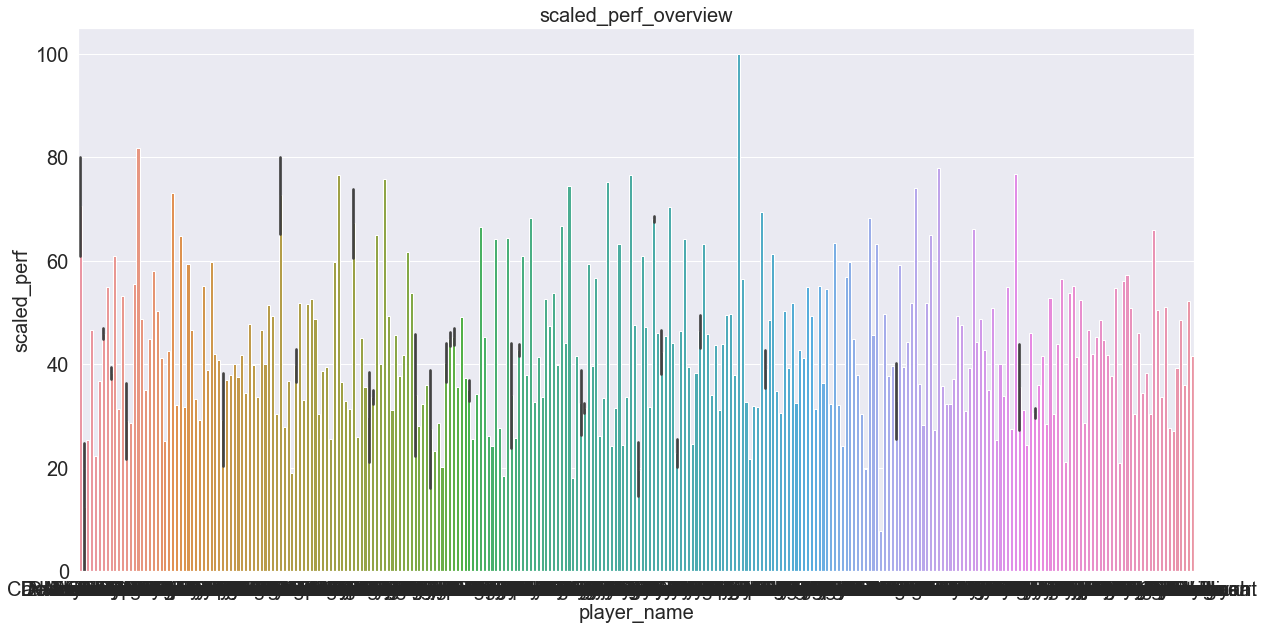

In [53]:
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="player_name", y="scaled_perf", data=df_performance_eval, ax=ax)
# plt.bar(df_performance_eval['player_name'], df_performance_eval['scaled_perf'])
plt.xlabel('player_name')
plt.ylabel("scaled_perf")
plt.title("scaled_perf_overview")
plt.show();

In [54]:
df_performance_eval_std = df_performance_eval.sort_values(df_performance_eval.columns[2])

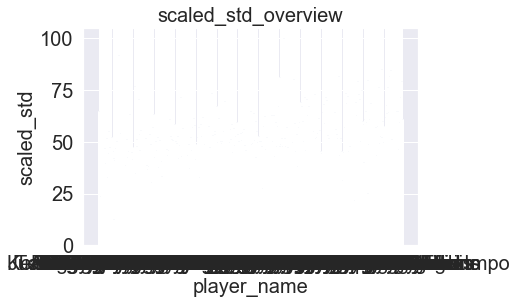

In [55]:
plt.figure()
plt.bar(df_performance_eval_std['player_name'], df_performance_eval_std['scaled_std'])
plt.xlabel('player_name')
plt.ylabel("scaled_std")
plt.title("scaled_std_overview")
plt.show();

In [56]:
df_performance_eval

,own_team_name,player_name,avg_performance_score,avg_performance_deviation,scaled_perf,scaled_std
0,Atlanta Hawks,Alex Len,45.563475,17.454689,60.96,79.79
1,Atlanta Hawks,Allen Crabbe,22.897952,14.577444,24.74,64.69
2,Atlanta Hawks,Cameron Reddish,23.283500,10.412795,25.35,42.85
3,Atlanta Hawks,Damian Jones,36.633484,9.562846,46.69,38.39
4,Atlanta Hawks,De'Andre Hunter,21.334607,11.168162,22.24,46.81
...,...,...,...,...,...,...
316,Washington Wizards,Moritz Wagner,37.744968,15.876699,48.46,71.51
317,Washington Wizards,Rui Hachimura,29.905079,11.983391,35.93,51.09
318,Washington Wizards,Shabazz Napier,29.518013,12.569848,35.32,54.16
319,Washington Wizards,Thomas Bryant,40.124896,9.824919,52.27,39.76
